In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os  # Import the os module to manage file path

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power', color='blue')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Make sure the ./fig directory exists, if not, create it
    os.makedirs('./fig', exist_ok=True)
    # Save the figure
    plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    plt.show()

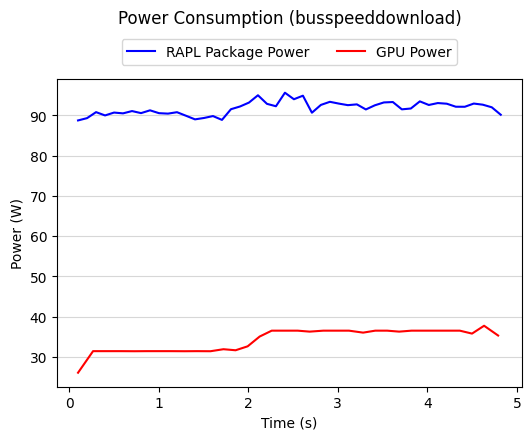

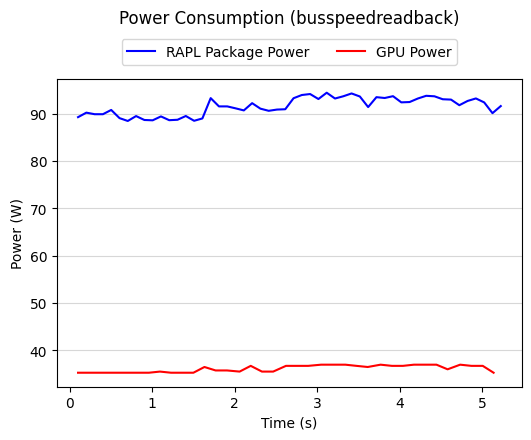

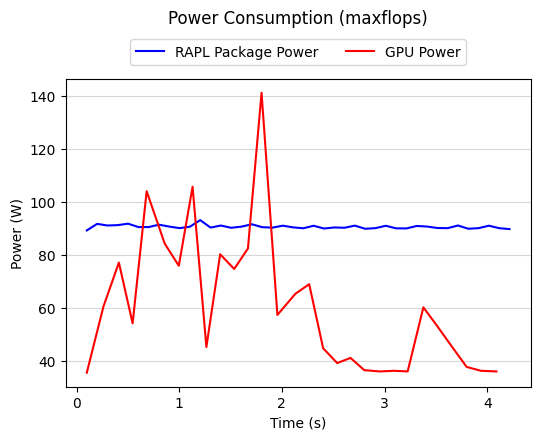

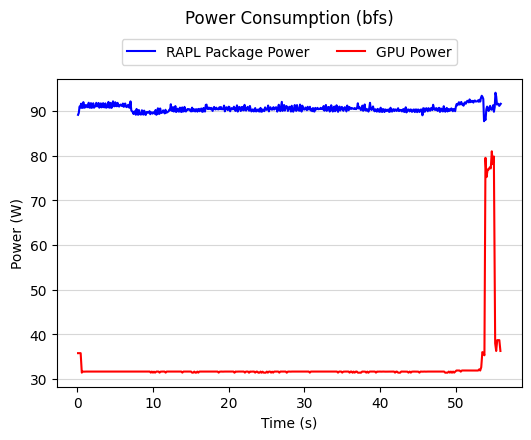

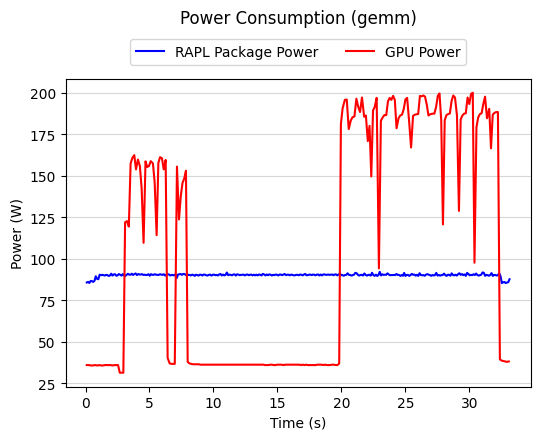

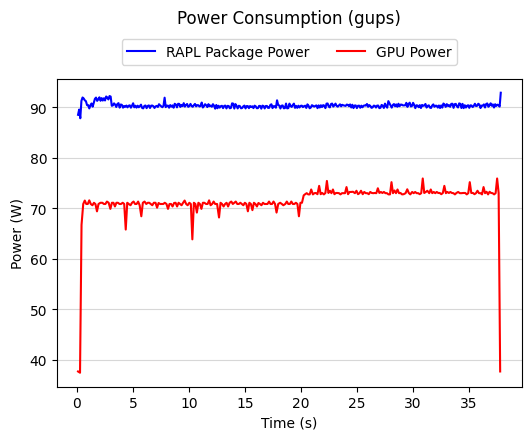

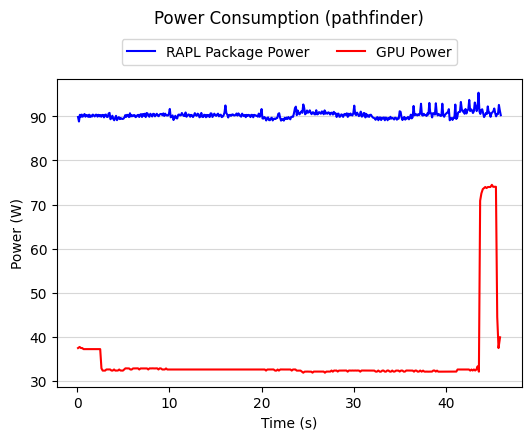

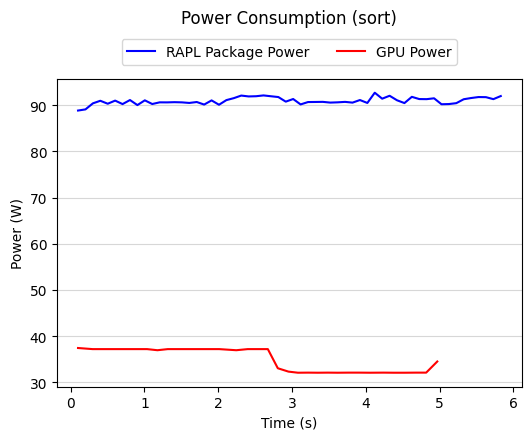

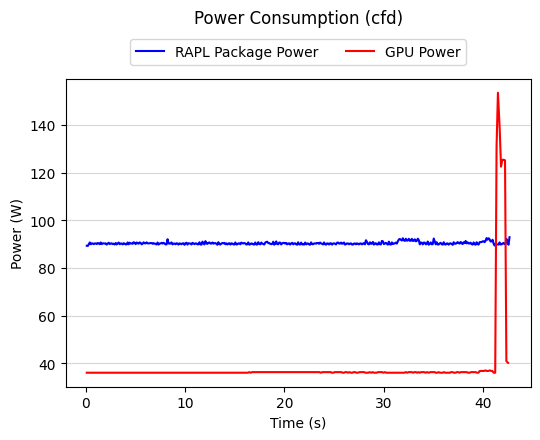

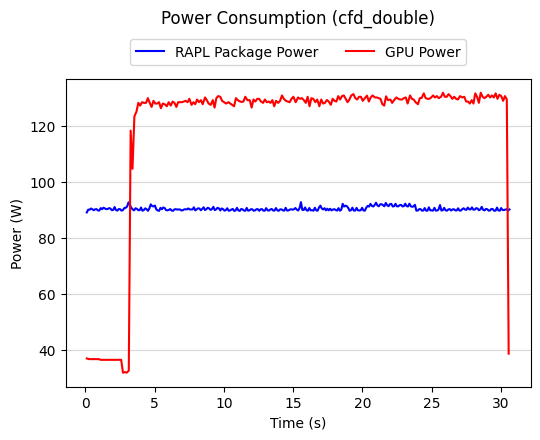

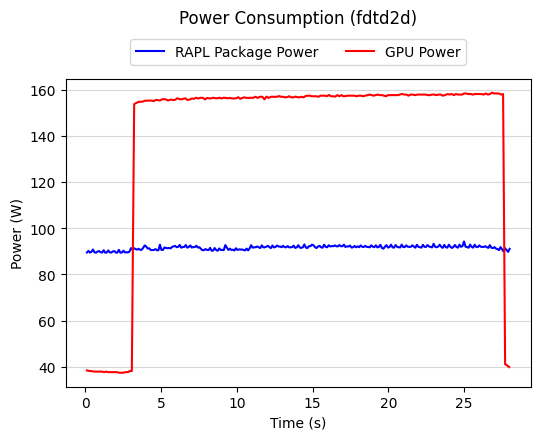

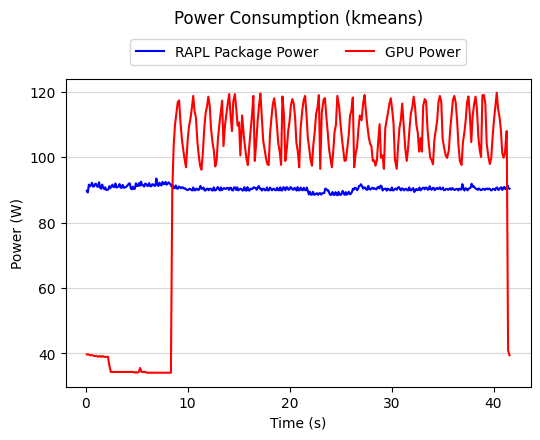

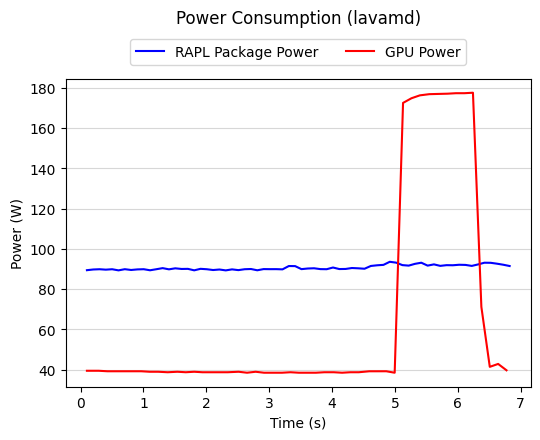

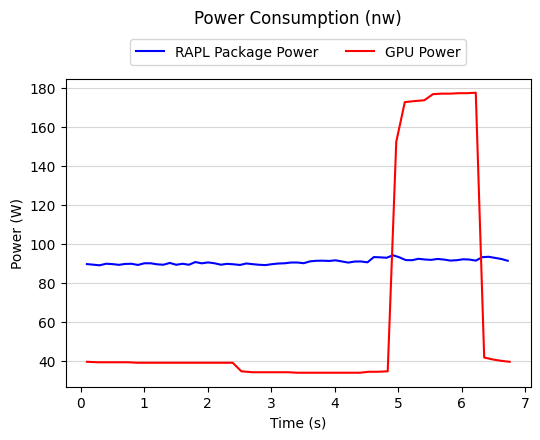

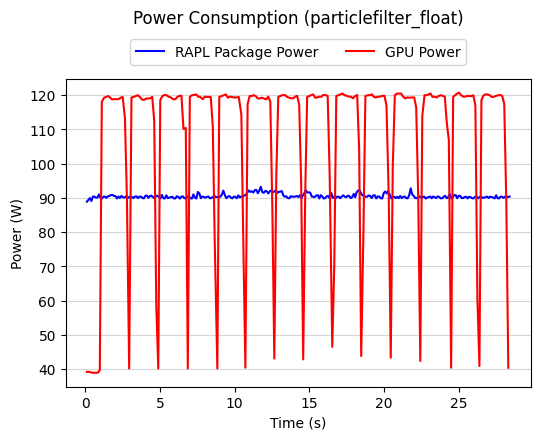

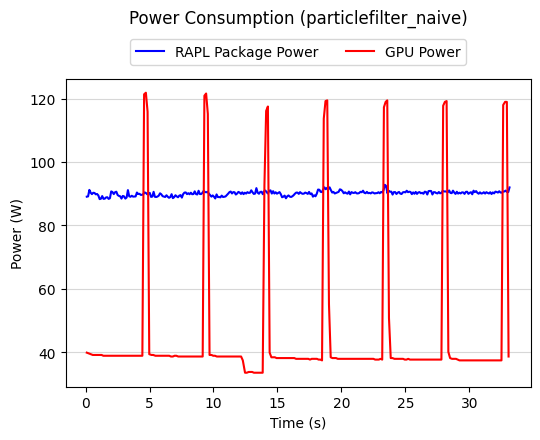

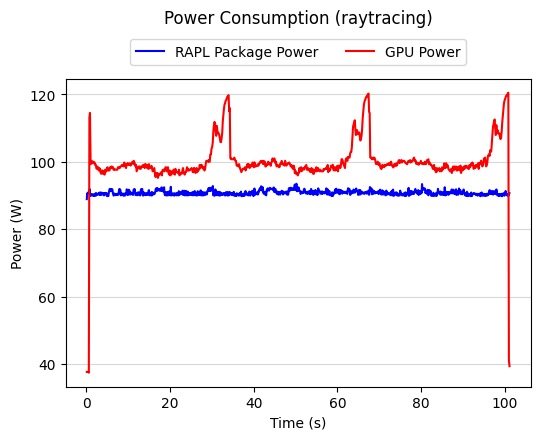

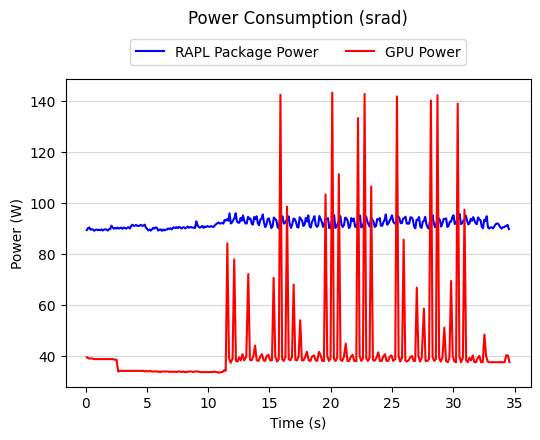

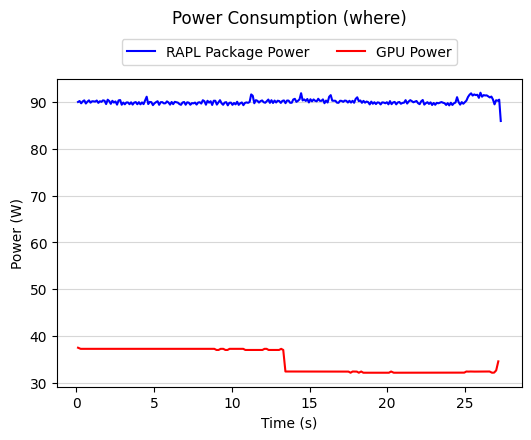

In [3]:
data_dir = "./altis_power_res/p100/"

# altis_benchmarks_0
busspeeddownload_cpu = data_dir + "busspeeddownload_power_cpu.csv"
busspeeddownload_gpu = data_dir + "busspeeddownload_power_gpu.csv"

busspeedreadback_cpu = data_dir + "busspeedreadback_power_cpu.csv"
busspeedreadback_gpu = data_dir + "busspeedreadback_power_gpu.csv"

maxflops_cpu = data_dir + "maxflops_power_cpu.csv"
maxflops_gpu = data_dir + "maxflops_power_gpu.csv"

# altis_benchmarks_1
bfs_cpu = data_dir + "bfs_power_cpu.csv"
bfs_gpu = data_dir + "bfs_power_gpu.csv"

gemm_cpu = data_dir + "gemm_power_cpu.csv"
gemm_gpu = data_dir + "gemm_power_gpu.csv"

gups_cpu = data_dir + "gups_power_cpu.csv"
gups_gpu = data_dir + "gups_power_gpu.csv"

pathfinder_cpu = data_dir + "pathfinder_power_cpu.csv"
pathfinder_gpu = data_dir + "pathfinder_power_gpu.csv"

sort_cpu = data_dir + "sort_power_cpu.csv"
sort_gpu = data_dir + "sort_power_gpu.csv"

# altis_benchmarks_2
cfd_cpu = data_dir + "cfd_power_cpu.csv"
cfd_gpu = data_dir + "cfd_power_gpu.csv"

cfd_double_cpu = data_dir + "cfd_double_power_cpu.csv"
cfd_double_gpu = data_dir + "cfd_double_power_gpu.csv"


fdtd2d_cpu = data_dir + "fdtd2d_power_cpu.csv"
fdtd2d_gpu = data_dir + "fdtd2d_power_gpu.csv"

kmeans_cpu = data_dir + "kmeans_power_cpu.csv"
kmeans_gpu = data_dir + "kmeans_power_gpu.csv"

lavamd_cpu = data_dir + "lavamd_power_cpu.csv"
lavamd_gpu = data_dir + "lavamd_power_gpu.csv"

nw_cpu = data_dir + "nw_power_cpu.csv"
nw_gpu = data_dir + "nw_power_gpu.csv"

particlefilter_float_cpu = data_dir + "particlefilter_float_power_cpu.csv"
particlefilter_float_gpu = data_dir + "particlefilter_float_power_gpu.csv"

particlefilter_naive_cpu = data_dir + "particlefilter_naive_power_cpu.csv"
particlefilter_naive_gpu = data_dir + "particlefilter_naive_power_gpu.csv"

raytracing_cpu = data_dir + "raytracing_power_cpu.csv"
raytracing_gpu = data_dir + "raytracing_power_gpu.csv"

srad_cpu = data_dir + "srad_power_cpu.csv"
srad_gpu = data_dir + "srad_power_gpu.csv"

where_cpu = data_dir + "where_power_cpu.csv"
where_gpu = data_dir + "where_power_gpu.csv"

# altis_benchmarks_0
plot_power_CPU_GPU(busspeeddownload_cpu, busspeeddownload_gpu, "busspeeddownload")
plot_power_CPU_GPU(busspeedreadback_cpu, busspeedreadback_gpu, "busspeedreadback")
plot_power_CPU_GPU(maxflops_cpu, maxflops_gpu, "maxflops")

# altis_benchmarks_1
plot_power_CPU_GPU(bfs_cpu, bfs_gpu, "bfs")
plot_power_CPU_GPU(gemm_cpu, gemm_gpu, "gemm")
plot_power_CPU_GPU(gups_cpu, gups_gpu, "gups")
plot_power_CPU_GPU(pathfinder_cpu, pathfinder_gpu, "pathfinder")
plot_power_CPU_GPU(sort_cpu, sort_gpu, "sort")

# altis_benchmarks_2
plot_power_CPU_GPU(cfd_cpu, cfd_gpu, "cfd")
plot_power_CPU_GPU(cfd_double_cpu, cfd_double_gpu, "cfd_double")
# plot_power_CPU_GPU(dwt2d_cpu, dwt2d_gpu, "dwt2d")
plot_power_CPU_GPU(fdtd2d_cpu, fdtd2d_gpu, "fdtd2d")
plot_power_CPU_GPU(kmeans_cpu, kmeans_gpu, "kmeans")
plot_power_CPU_GPU(lavamd_cpu, lavamd_gpu, "lavamd")
# plot_power_CPU_GPU(mandelbrot_cpu, mandelbrot_gpu, "mandelbrot")
plot_power_CPU_GPU(nw_cpu, nw_gpu, "nw")
plot_power_CPU_GPU(particlefilter_float_cpu, particlefilter_float_gpu, "particlefilter_float")
plot_power_CPU_GPU(particlefilter_naive_cpu, particlefilter_naive_gpu, "particlefilter_naive")
plot_power_CPU_GPU(raytracing_cpu, raytracing_gpu, "raytracing")
plot_power_CPU_GPU(srad_cpu, srad_gpu, "srad")
plot_power_CPU_GPU(where_cpu, where_gpu, "where")